# Computer Vision III: Detection, Segmentation and Tracking (CV3DST) (IN2375) Exercise

In this exercise we provide you with a baseline multi-object tracker on the [MOT16](https://motchallenge.net/data/MOT16/) dataset. The goal is for you to familiarize yourself with the dataset, obtain some preliminary baseline results, and test the submission system, as these will be used through all the exercises. If you already have some ideas on how to improve this baseline, also feel free to play around with them. **Note that this exercise will not be graded**. 

As most modern multi-object trackers, the provided baseline follows the tracking-by-detection paradigm. To this end, an object detector is applied to each frame indepdently and in a subsequent data association step the detections are combined to tracks over multiple frames. The challenge is to connect the correct detections of the same object and produce identity preserving tracks.


In the upcoming exercise assignments, we will extend this tracker with different techniques to improve its performance. The end goal will be for you to combine all the tools we will develop to obtain a top-performing multi-object tracker. The final tracker you will have created by the end of the semester will be benchmarked in a final competition.

## Setup

### Download and extract project data to your Google Drive

1.   Install Google Drive on your desktop.
2.   Save this notebook to your Google Drive by clicking `Save a copy in Drive` from the `File` menu.
3.   Download [this](https://vision.in.tum.de/webshare/u/brasoand/cv3dst/cv3dst_exercise.zip) zip file to your desktop and extract it into the `Colab Notebooks` folder in your Google Drive.
4.   Wait until Google Drive finished the synchronisation. (This might take a while.)


#### Connect the notebook to your Google Drive

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
root_dir = "gdrive/My Drive/Colab Notebooks/cv3dst_exercise"

The `root_dir` path points to the directory and the content in your Google Drive.

In [3]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise"
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/src/tracker"

data  models  output  src
data_obj_detect.py  __init__.py		__pycache__  utils.py
data_track.py	    object_detector.py	tracker.py


#### Install and import Python libraries

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.join(root_dir, 'src'))

!pip install tqdm lap
!pip install https://github.com/timmeinhardt/py-motmetrics/archive/fix_pandas_deprecating_warnings.zip

     |████████████████████████████████| 1.5 MB 5.4 MB/s 
  Created wheel for lap: filename=lap-0.4.0-cp37-cp37m-linux_x86_64.whl size=1590157 sha256=b6872d37c6f29d8e6dd7db7538df1a39d44637a60e450fd5d1ac5fa4e9307a26
  Stored in directory: /root/.cache/pip/wheels/b1/0b/e3/ef9daf1b5547b56389e42c80c3100f1e6479bf5fd00fd9d6ba
Successfully built lap
     / 148 kB 1.2 MB/s
  Created wheel for motmetrics: filename=motmetrics-1.1.3-py3-none-any.whl size=134199 sha256=e1b04b5faadbeb335c4ca2b020f64785bf15911e1848cc1da28b7dd59e38f60a
  Stored in directory: /tmp/pip-ephem-wheel-cache-23u2dwp2/wheels/39/60/bf/90b1b02ff42db1bf7f2d2fa3eef2fe8bc46061182cf4ce7b37
Successfully built motmetrics


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.autonotebook import tqdm

import torch
from torch.utils.data import DataLoader

from tracker.data_track import MOT16Sequences
from tracker.data_obj_detect import MOT16ObjDetect
from tracker.object_detector import FRCNN_FPN
from tracker.tracker import Tracker
from tracker.utils import (plot_sequence, evaluate_mot_accums, get_mot_accum,
                           evaluate_obj_detect, obj_detect_transforms)

import motmetrics as mm
mm.lap.default_solver = 'lap'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  after removing the cwd from sys.path.


# MOT16 dataset

The MOT16 challenge provides 7 train and 7 test video sequences with multiple objects (pedestrians) per frame. It includes many challening scenarios with camera movement, high crowdedness and object occlusions. See the [webpage](https://motchallenge.net/data/MOT16/) for video sequences with ground truth annotation.

The `MOT17Sequences` dataset class provides the possibilty to load single sequences, e.g., `seq_name = 'mot16_02'`, or the entire train/test set, e.g., `seq_name = 'mot16_train'`.


In [6]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/train"
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/data/MOT16/test"

MOT16-02  MOT16-04  MOT16-05  MOT16-09	MOT16-10  MOT16-11  MOT16-13
MOT16-01  MOT16-03  MOT16-06  MOT16-07	MOT16-08  MOT16-12  MOT16-14


In order to compare the tracking performance of different trackers without the effect of the object detector, the MOTChallenge provides a precomputed set of public object detections. Trackers are then evaluated on their capabilities to form tracks with the provided set. However, we want to allow you to improve on the object detections as well. Therefore, we participate in the MOT16 challenge with private detections.

## Instance segmentations

We provide the instance segmentations for the sequences `02`, `05`, `09` and `11`. These can be used for example to train a method which improves the bounding box position in occluded situations. See the original MOTS [webpage](https://www.vision.rwth-aachen.de/page/mots) for more info.

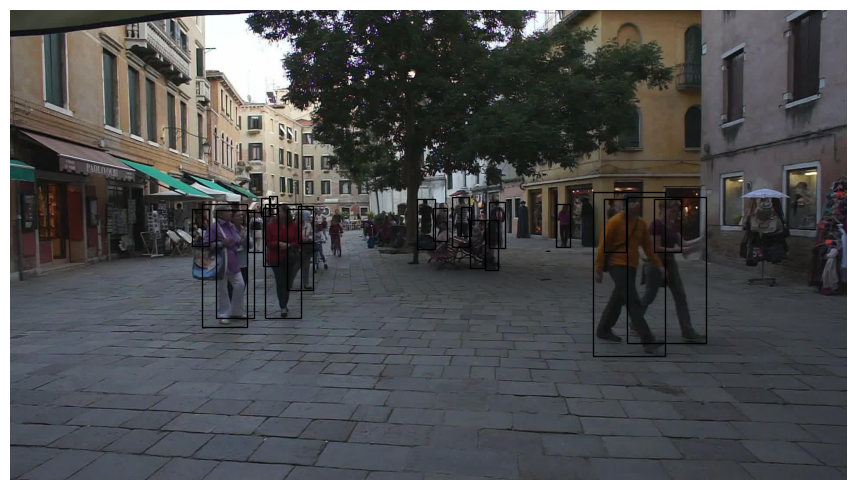

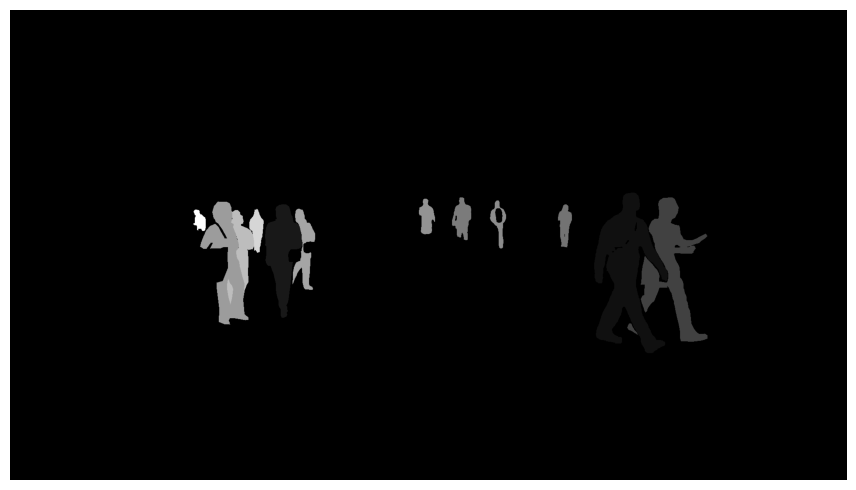

In [7]:
seq_name = 'MOT16-02'
data_dir = os.path.join(root_dir, 'data/MOT16')
sequences = MOT16Sequences(seq_name, data_dir, load_seg=True)

for seq in sequences:
    for i, frame in enumerate(seq):
        img = frame['img']
        
        dpi = 96
        fig, ax = plt.subplots(1, dpi=dpi)

        img = img.mul(255).permute(1, 2, 0).byte().numpy()
        width, height, _ = img.shape
          
        ax.imshow(img, cmap='gray')
        fig.set_size_inches(width / dpi, height / dpi)

        if 'gt' in frame:
            gt = frame['gt']
            for gt_id, box in gt.items():
                rect = plt.Rectangle(
                  (box[0], box[1]),
                  box[2] - box[0],
                  box[3] - box[1],
                  fill=False,
                  linewidth=1.0)
                ax.add_patch(rect)

        plt.axis('off')
        plt.show()

        if 'seg_img' in frame:
            seg_img = frame['seg_img']
            fig, ax = plt.subplots(1, dpi=dpi)
            fig.set_size_inches(width / dpi, height / dpi)
            ax.imshow(seg_img, cmap='gray')
            plt.axis('off')
            plt.show()
        break

# Object detector

We provide you with an object detector pretrained on the MOT challenge training set. This detector can be used and improved to generate the framewise detections necessary for the subsequent tracking and data association step.

The object detector is a [Faster R-CNN](https://arxiv.org/abs/1506.01497) with a Resnet50 feature extractor. We trained the native PyTorch implementation of Faster-RCNN. For more information check out the corresponding PyTorch [webpage](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

In [8]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/models"

faster_rcnn_fpn.model



## Configuration

In [9]:
obj_detect_model_file = os.path.join(root_dir, 'models/faster_rcnn_fpn.model')
obj_detect_nms_thresh = 0.3

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# object detector
obj_detect = FRCNN_FPN(num_classes=2, nms_thresh=obj_detect_nms_thresh)
obj_detect_state_dict = torch.load(obj_detect_model_file,
                                   map_location=lambda storage, loc: storage)
obj_detect.load_state_dict(obj_detect_state_dict)
obj_detect.eval()
obj_detect.to(device)

FRCNN_FPN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu)

If you uncomment und run the following evaluation of the object detection training set, you should obtain the following evaluation result:
`AP: 0.8457444638354537 Prec: 0.9225361204680697 Rec: 0.9166831885241122 TP: 78601.0 FP: 6600.0`

In [11]:
dataset_test = MOT16ObjDetect(os.path.join(root_dir, 'data/MOT16/train'),
                              obj_detect_transforms(train=False))
def collate_fn(batch):
    return tuple(zip(*batch))
data_loader_test = DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

evaluate_obj_detect(obj_detect, data_loader_test) # <-- takes a while.

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/5316 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


AP: 0.849414356080157 Prec: 0.9225361204680697 Rec: 0.9166831885241122 TP: 78601.0 FP: 6600.0


# Multi-object tracking

We provide you with a simple baseline tracker which predicts object detections for each frame and generates tracks by assigning current detections to previous detections via Intersection over Union.

Try to understand the baseline tracker and think of ideas on how to improve it with the knowledge from the lecture or even beyond.

## Configuration

In [12]:
seed = 12345
seq_name = 'MOT16-02'
data_dir = os.path.join(root_dir, 'data/MOT16')
output_dir = os.path.join(root_dir, 'output')

## Setup

In [13]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

# dataset
sequences = MOT16Sequences(seq_name, data_dir)

# tracker
class TrackerIoUAssignment(Tracker):

    def data_association(self, boxes, scores):
        if self.tracks:
            track_ids = [t.id for t in self.tracks]
            track_boxes = np.stack([t.box.numpy() for t in self.tracks], axis=0)
            
            distance = mm.distances.iou_matrix(track_boxes, boxes.numpy(), max_iou=0.5)

            # update existing tracks
            remove_track_ids = []
            for t, dist in zip(self.tracks, distance):
                if np.isnan(dist).all():
                    remove_track_ids.append(t.id)
                else:
                    match_id = np.nanargmin(dist)
                    t.box = boxes[match_id]
            self.tracks = [t for t in self.tracks
                           if t.id not in remove_track_ids]

            # add new tracks
            new_boxes = []
            new_scores = []
            for i, dist in enumerate(np.transpose(distance)):
                if np.isnan(dist).all():
                    new_boxes.append(boxes[i])
                    new_scores.append(scores[i])
            self.add(new_boxes, new_scores)

        else:
            self.add(boxes, scores)
        

tracker = TrackerIoUAssignment(obj_detect)

## Run tracker

In [14]:
time_total = 0
mot_accums = []
results_seq = {}
for seq in sequences:
    tracker.reset()
    now = time.time()

    print(f"Tracking: {seq}")

    data_loader = DataLoader(seq, batch_size=1, shuffle=False)

    for frame in tqdm(data_loader):
        tracker.step(frame)
    results = tracker.get_results()
    results_seq[str(seq)] = results

    if seq.no_gt:
        print(f"No GT evaluation data available.")
    else:
        mot_accums.append(get_mot_accum(results, seq))

    time_total += time.time() - now

    print(f"Tracks found: {len(results)}")
    print(f"Runtime for {seq}: {time.time() - now:.1f} s.")

    seq.write_results(results, os.path.join(output_dir))

print(f"Runtime for all sequences: {time_total:.1f} s.")
if mot_accums:
    evaluate_mot_accums(mot_accums,
                        [str(s) for s in sequences if not s.no_gt],
                        generate_overall=True)

Tracking: MOT16-02


  0%|          | 0/600 [00:00<?, ?it/s]

Tracks found: 50
Runtime for MOT16-02: 307.3 s.
Writing predictions to: gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/MOT16-02.txt
Runtime for all sequences: 307.3 s.
          IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML   FP    FN IDs  FM  MOTA  MOTP
MOT16-02 32.2% 49.8% 23.8% 30.8% 64.4% 62  5 22 35 3170 12858  52  91 13.5% 0.086
OVERALL  32.2% 49.8% 23.8% 30.8% 64.4% 62  5 22 35 3170 12858  52  91 13.5% 0.086


The current state-of-the-art multi-object tracker [Tracktor++](https://arxiv.org/abs/1903.05625) achieves the following tracking results on the `MOT16-train` sequences:

              IDF1   IDP   IDR  Rcll  Prcn  GT  MT  PT  ML  FP    FN IDs   FM  MOTA  MOTP
    MOT16-02 45.8% 78.3% 32.4% 41.3% 99.8%  62   9  32  21  18 10909  59   68 40.9% 0.080
    MOT16-04 71.1% 90.3% 58.6% 64.7% 99.8%  83  32  29  22  71 16785  22   29 64.5% 0.096
    MOT16-05 64.0% 86.6% 50.7% 57.5% 98.1% 133  32  65  36  75  2942  37   59 55.8% 0.144
    MOT16-09 54.6% 69.4% 45.0% 64.3% 99.1%  26  11  13   2  31  1903  22   31 63.3% 0.086
    MOT16-10 64.3% 75.7% 55.9% 72.4% 98.0%  57  28  26   3 189  3543  71  125 70.4% 0.148
    MOT16-11 63.3% 77.0% 53.7% 69.0% 98.9%  75  24  33  18  73  2924  26   26 68.0% 0.081
    MOT16-13 73.6% 85.1% 64.8% 74.2% 97.6% 110  60  39  11 213  3000  62   90 71.9% 0.132
    OVERALL  65.0% 84.0% 53.1% 62.6% 99.1% 546 196 237 113 670 42006 299  428 61.7% 0.106

For your final submission you should focus on improving both `MOTA` and `IDF1`.

## Visualize tracking results

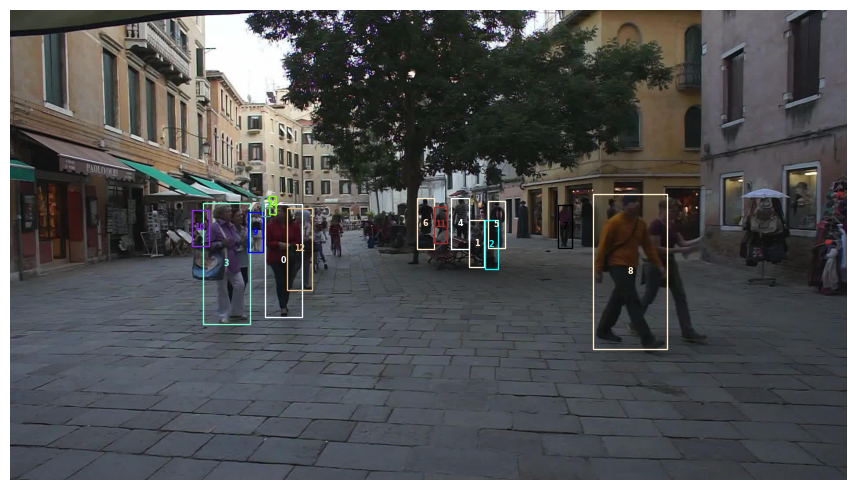

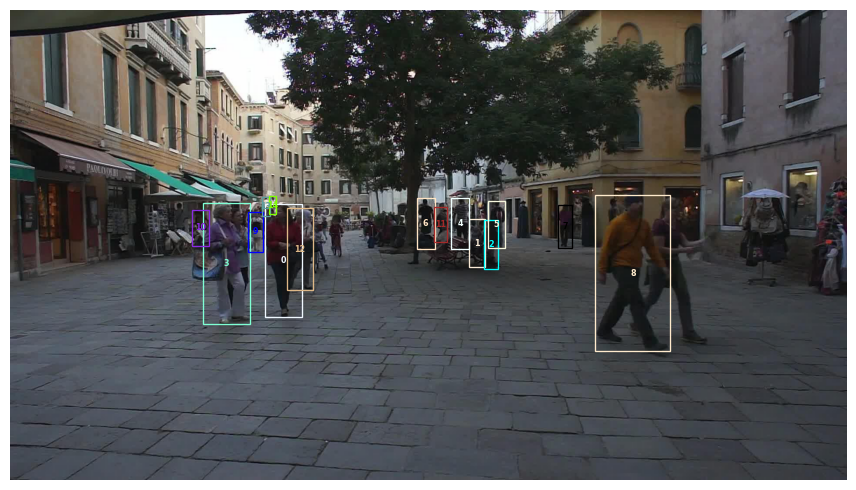

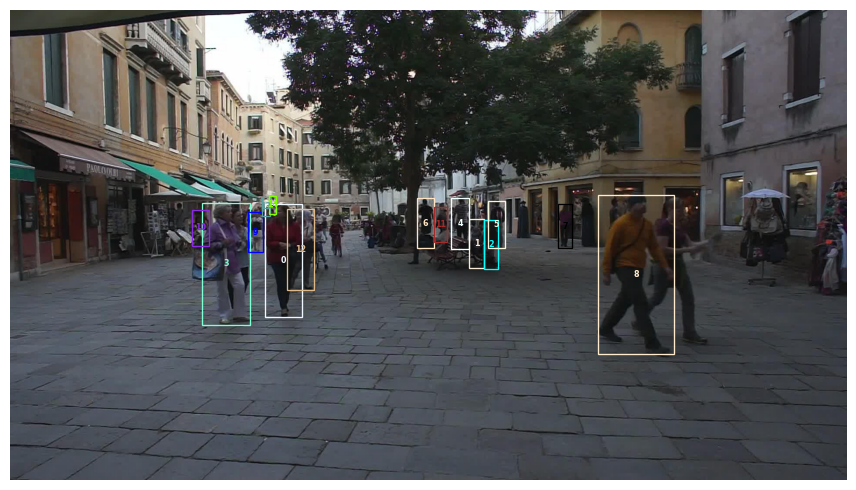

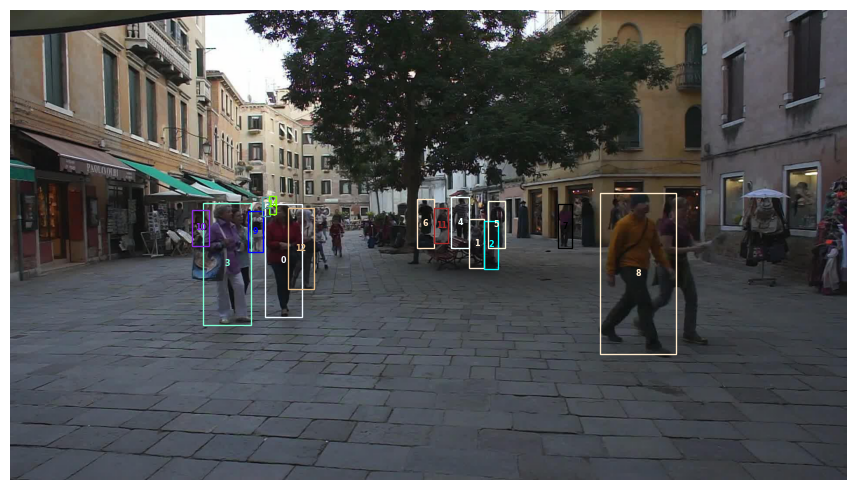

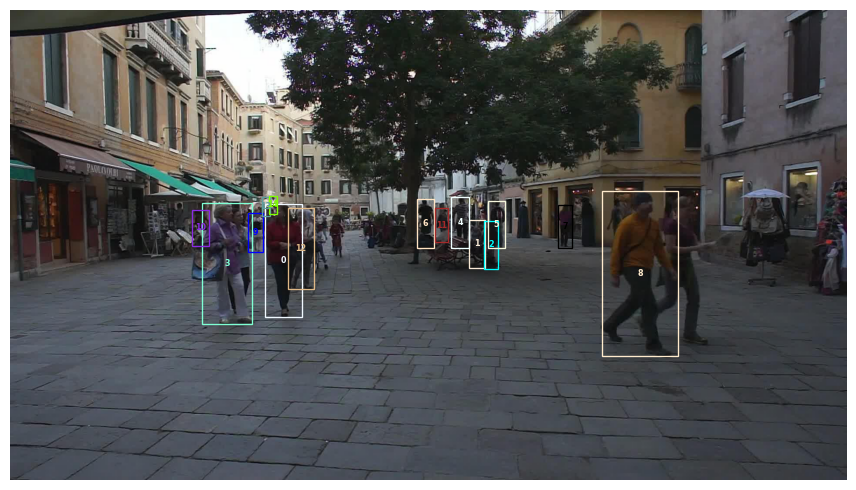

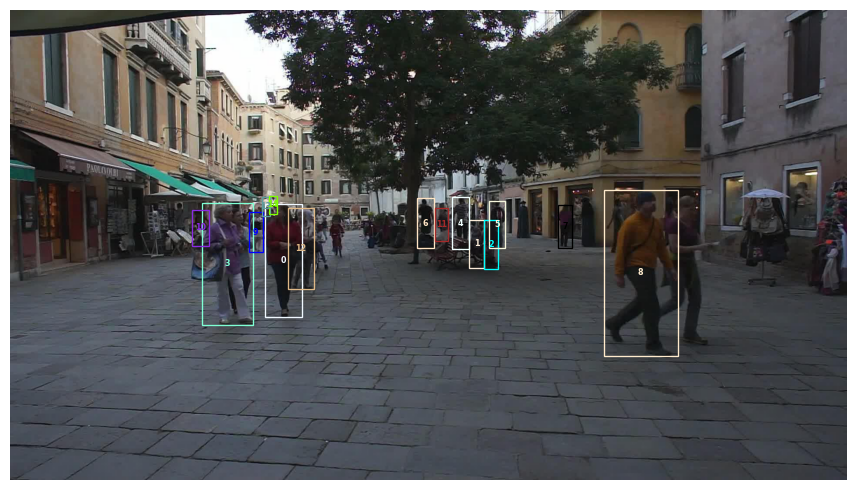

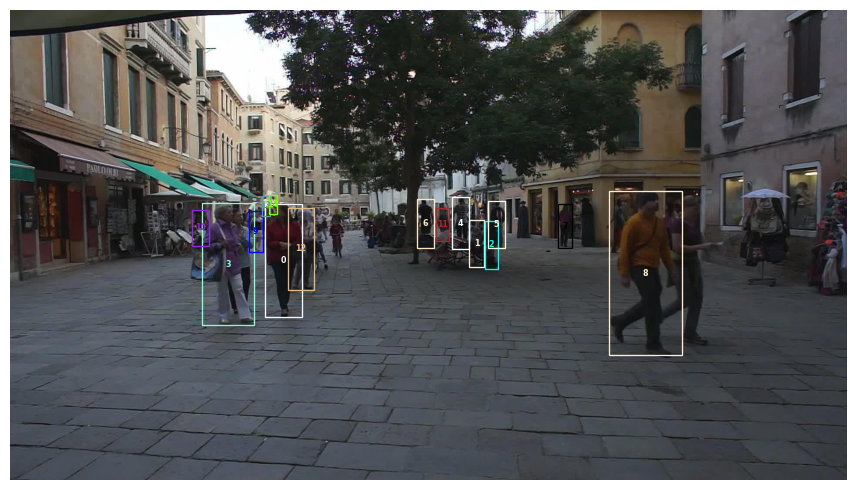

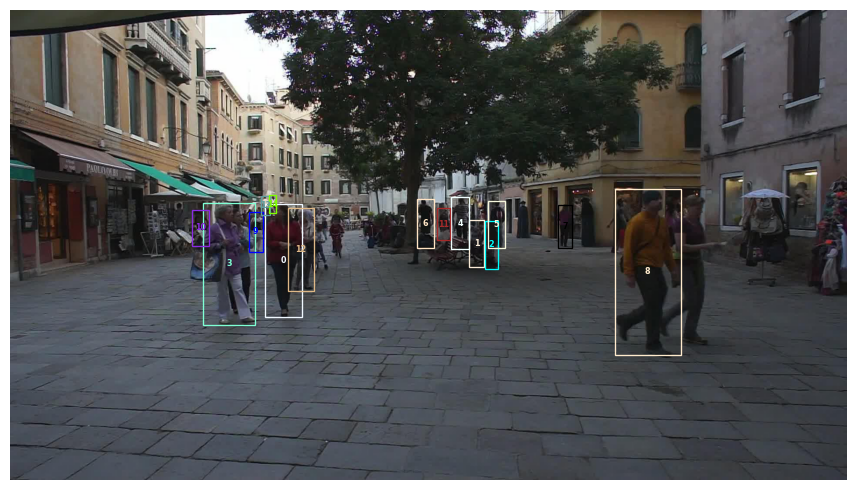

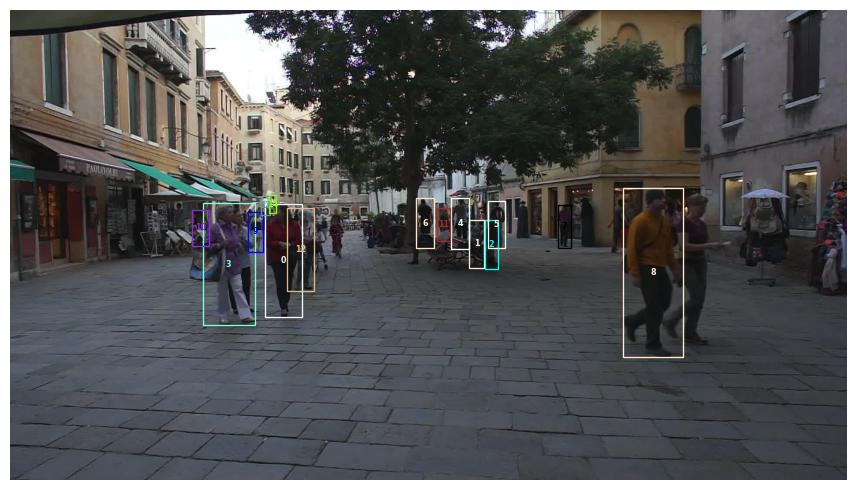

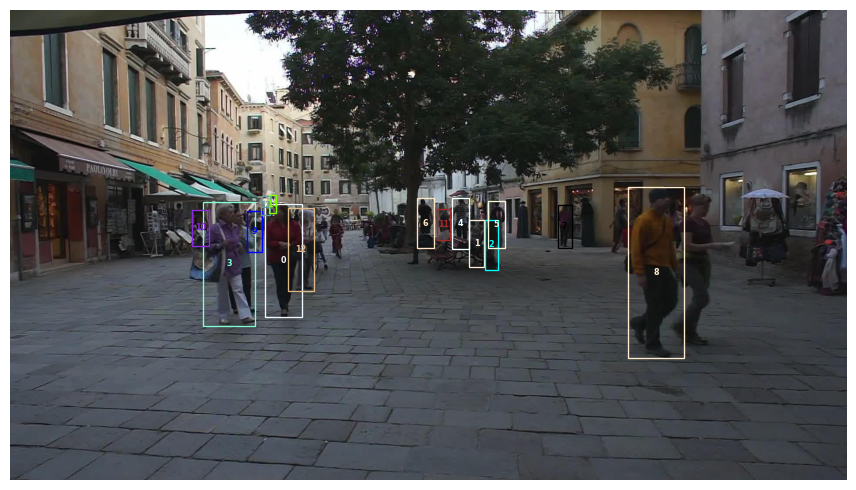

In [15]:
plot_sequence(results_seq['MOT16-02'],
              [s for s in sequences if str(s) == 'MOT16-02'][0],
              first_n_frames=10)

# Notes and next steps

*   Experiment and debug on a single train sequence. If something works on a single sequence evaluate all train sequences to check the generaliztion of your improvement.
*   Remember to split the training set into multiple sets with different sequences if you train something and want to avoid overfitting.
*   Sometimes the execution of a cell gets stuck. If this happends just abort the execution and restart the cell.
*   If the notebook warns you that currently no GPU hardware acceleration is available, try again later and focus on some debugging or experiments than can be done only with the CPU.
* Try to improve your results on your local train/validation splits before submitting to our test servers. The submission will be limited to avoid overfitting to the test sequences.


# Exercise submission

The `seq.write_results(results, os.path.join(output_dir))` statement saves predicted tracks into files. After executing this notebook the `output` directory in your Google Drive should contain multiple `MOT16-XY.txt` files.

For the final submission you have to process the test sequences and upload the zipped prediction files to our server. More information on this will follow.


In [16]:
!ls "gdrive/My Drive/Colab Notebooks/cv3dst_exercise/output/"

MOT16-02.txt  MOT16-05.txt  MOT16-10.txt  MOT16-13.txt
MOT16-04.txt  MOT16-09.txt  MOT16-11.txt
